## 1. Import libraries and data

In [1]:
# import libraries
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
# read test and train data, print shapes
test = pd.read_csv('datasets/test.csv')
train = pd.read_csv('datasets/train.csv')
train.shape, test.shape

((2051, 81), (878, 80))

In [11]:
train.isna().sum() > 0

Id              False
PID             False
MS SubClass     False
MS Zoning       False
Lot Frontage     True
                ...  
Misc Val        False
Mo Sold         False
Yr Sold         False
Sale Type       False
SalePrice       False
Length: 81, dtype: bool

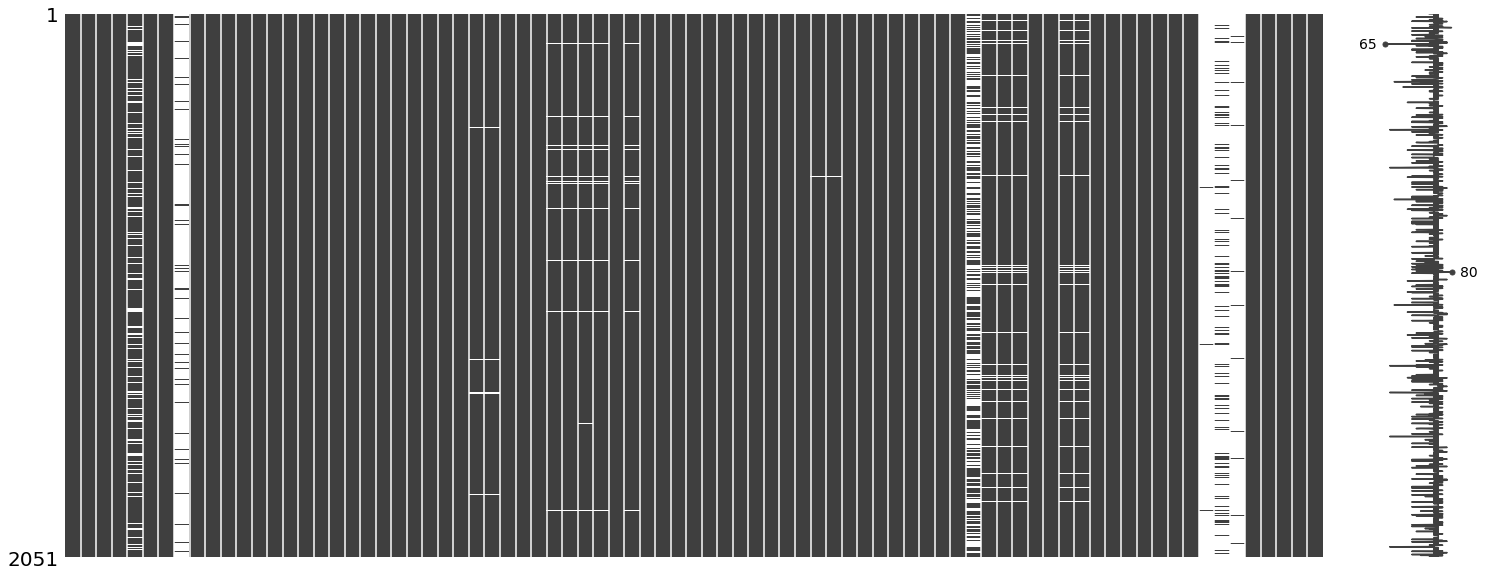

In [5]:
import missingno as mno
mno.matrix(train[(train.isna().sum() > 0).index])

In [3]:
train.dtypes.value_counts()

object     42
int64      28
float64    11
dtype: int64

### Convert ordinal features:
Conversions based on data dictionary at http://web.stanford.edu/class/stats191/data/amesdoc.txt

In [16]:
# mapping over categories with standard 'Excellent'-'Poor' scale (10 features)
ex_po_mapper =  { 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
ex_po_cols = ['Exter Qual', 'Exter Cond', 'Bsmt Cond', 'Bsmt Qual',
               'Heating QC', 'Kitchen Qual', 'Fireplace Qu', 'Garage Qual',
               'Garage Cond', 'Pool QC']

for col in ex_po_cols:
    train[col] = train[col].replace(ex_po_mapper).astype('float')

In [17]:
# mapping over BsmtFin Types (2 features)
bsmtft_mapper =  { 'Unf': 1, 'LwQ': 3, 'Rec': 5, 'BLQ': 7, 'ALQ': 8, 'GLQ': 9, }
bsmt_fincols = ['BsmtFin Type 1', 'BsmtFin Type 2']
for col in bsmt_fincols:
    train[col] = train[col].replace(bsmtft_mapper).astype('float')

In [18]:
# mapping unique ordinals (9 features)
ordinal_maps = {
    'Lot Shape': { 'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4, },
    'Utilities': { 'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1, },
    'Land Slope': { 'Gtl': 1, 'Mod': 2, 'Sev': 3, },
    'Bsmt Exposure': { 'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1 },
    'Electrical': { 'SBrkr': 4, 'FuseA': 3, 'FuseF': 2, 'FuseP': 1, 'Mix': np.nan, },
    'Functional': { 'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1, },
    'Garage Finish': { 'Fin': 3, 'RFn': 2, 'Unf': 1, },
    'Paved Drive': { 'Y': 3, 'P': 2, 'N': 1, },
    'Fence': { 'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, },
}
    
for col, mapper in ordinal_maps.items():
        train[col] = train[col].replace(mapper).astype('float')

In [19]:
# getting there...
train.dtypes.value_counts()

float64    32
int64      28
object     21
dtype: int64

In [20]:
check_equal_columns()

NameError: name 'check_equal_columns' is not defined

Do all the same to our test data:

In [21]:
for col in ex_po_cols:
    test[col] = test[col].replace(ex_po_mapper).astype('float')
for col, mapper in ordinal_maps.items():
    test[col] = test[col].replace(mapper).astype('float')
for col in bsmt_fincols:
    test[col] = test[col].replace(bsmtft_mapper).astype('float')

In [22]:
check_equal_columns()

NameError: name 'check_equal_columns' is not defined

In [23]:
# Drop columns with weak correlation

In [24]:
train.corr()['SalePrice'].abs().sort_values()[:28].index

Index(['Misc Val', 'Yr Sold', 'BsmtFin SF 2', 'Pool Area', 'Utilities',
       'BsmtFin Type 2', 'Mo Sold', 'Exter Cond', 'Low Qual Fin SF',
       'Bsmt Half Bath', '3Ssn Porch', 'Id', 'Land Slope', 'MS SubClass',
       'Overall Cond', 'Kitchen AbvGr', 'Functional', 'Screen Porch',
       'Enclosed Porch', 'Bedroom AbvGr', 'Garage Cond', 'Bsmt Cond',
       'Bsmt Unf SF', 'Garage Qual', 'Fence', 'Electrical', '2nd Flr SF',
       'PID'],
      dtype='object')

In [25]:
weak_corr = list(train.corr()['SalePrice'].abs().sort_values()[:28].index)
weak_corr.remove('Id')
weak_corr

['Misc Val',
 'Yr Sold',
 'BsmtFin SF 2',
 'Pool Area',
 'Utilities',
 'BsmtFin Type 2',
 'Mo Sold',
 'Exter Cond',
 'Low Qual Fin SF',
 'Bsmt Half Bath',
 '3Ssn Porch',
 'Land Slope',
 'MS SubClass',
 'Overall Cond',
 'Kitchen AbvGr',
 'Functional',
 'Screen Porch',
 'Enclosed Porch',
 'Bedroom AbvGr',
 'Garage Cond',
 'Bsmt Cond',
 'Bsmt Unf SF',
 'Garage Qual',
 'Fence',
 'Electrical',
 '2nd Flr SF',
 'PID']

In [26]:
train = train.drop(columns=weak_corr)

In [27]:
test = test.drop(columns=weak_corr)

In [28]:
### Plot all features against SalePrice

In [29]:
fig = plt.figure(figsize=(16,16))
plt.subplots_adjust(hspace=.45)

pairplot_columns = train.drop(columns=['Id', 'MS SubClass']).columns

for i, feat in enumerate(train.columns):
    if feat != 'SalePrice':
        try:
            plt.subplot(10, 8, i+1)
            plt.scatter(train[feat], train['SalePrice'], s=2, alpha=.5)  
            plt.title('\n'+feat, fontsize=13)
            plt.tick_params(labelbottom=False, labelleft=False)   
        except:
            plt.title(feat, fontsize=12)
            plt.tick_params(labelbottom=False, labelleft=False)   

KeyError: "['MS SubClass'] not found in axis"

<Figure size 1152x1152 with 0 Axes>

In [30]:
def check_equal_columns(train=train, test=test):
    test_only = [feat for feat in test.columns if feat not in train.columns]
    train_only = [feat for feat in train.columns if feat not in test.columns]
    print('test columns not in train: {}\ntrain columns not in test: {}'.format(test_only, train_only))
check_equal_columns()

test columns not in train: []
train columns not in test: ['SalePrice']


In [31]:
train_heat = train.select_dtypes(exclude='object')

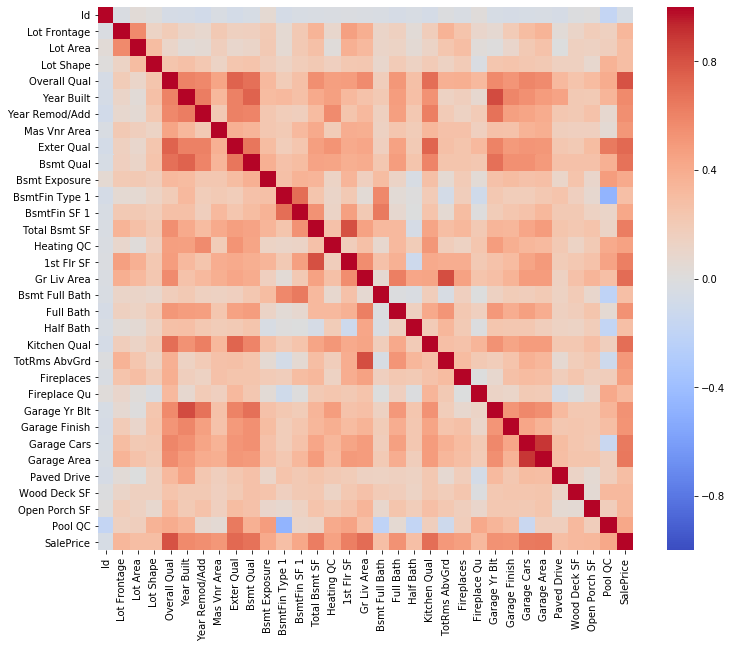

In [32]:
plt.figure(figsize=(12,10))
sns.heatmap(train_heat.corr(), cmap='coolwarm', vmin=-1, vmax=1)

#### Check for multicolinear variables

In [33]:
# define a function to check for multicollinear variables: 
def get_multicos(df, thresh, target='SalePrice'):
    multicol = df.corr().abs().unstack()[
        (df.corr().abs().unstack() > thresh) &
        (df.corr().abs().unstack() < 1)].to_frame().reset_index()
    multicol.drop_duplicates(0, keep='first', inplace=True)
    multicol = multicol[(multicol.level_0 != target) &
                        (multicol.level_1 != target)][['level_0', 'level_1']]
    multicos = []
    for row in range(len(multicol)):
        x = multicol.iloc[row]['level_0'], multicol.iloc[row]['level_1']
        multicos.append(x)
  # return variables with multicollinearity as tuples in a list:
    return multicos

#### Visualizing collinearity:

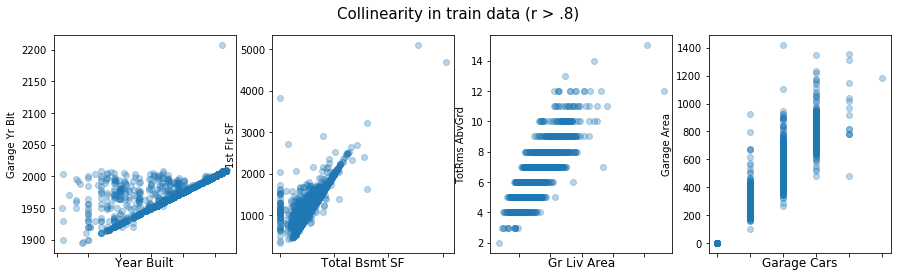

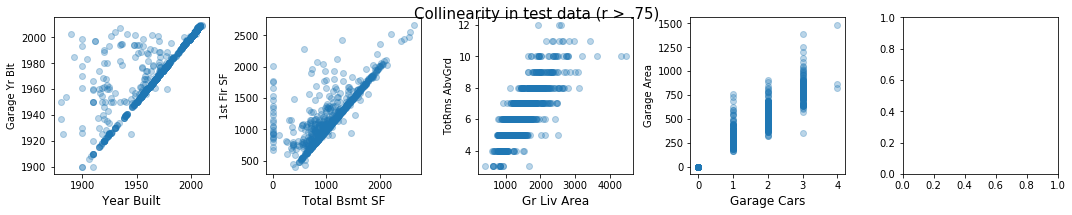

In [35]:
# get collinear features in TRAIN with r > .8
multicolist = [ pair for pair in get_multicos(train, .8) if 'Id' not in pair]

#plot...
fig, ax = plt.subplots(1, 4, figsize=(15,4))
for col, pair in enumerate(multicolist):
    ax[col].scatter(train[pair[0]], train[pair[1]], alpha=.3,)  
    ax[col].set_xlabel(pair[0], fontsize=12)
    ax[col].tick_params(labelbottom=False)    
    ax[col].set_ylabel(pair[1])
plt.suptitle('Collinearity in train data (r > .8)', fontsize=15)
plt.show()

# get collinear features in TEST with r > .75
multicolist_test = [ pair for pair in get_multicos(test, .75) if 'Pool QC' not in pair and 'Id' not in pair ]

#plot...
fig, ax = plt.subplots(1, 5, figsize=(15,3))
fig.subplots_adjust(wspace=.5) 
for col, pair in enumerate(multicolist_test):
    ax[col].scatter(test[pair[0]], test[pair[1]], alpha=.3)  
    ax[col].set_xlabel(pair[0], fontsize=12)
    ax[col].set_ylabel(pair[1])
plt.suptitle('Collinearity in test data (r > .75)', fontsize=15)
plt.tight_layout()

In [ ]:
check_equal_columns()

#### Drop weaker in pairs of variables exhibiting multicollinearity

In [ ]:
# combine multicollinear variables:

def remove_multicos(test, train, multicolist=multicolist):
    # for pair of multicollinear variables:
    for xs in multicolist:
        # check correlation to target variable, drop column with weaker correlation
        if train.corr()['SalePrice'][xs[0]] > train.corr()['SalePrice'][xs[1]]:
            print('\n———————',xs[0],'vs.',xs[1],'———————',)
            print(xs[0], 'corr with SalePrice:', round(train.corr()['SalePrice'][xs[0]], 3), '(kept)')
            print(xs[1], 'corr with SalePrice:', round(train.corr()['SalePrice'][xs[1]], 3), '(dropped)')        
            train.drop(xs[1], axis = 1, inplace = True)
            test.drop(xs[1], axis = 1, inplace = True)
        else:
            print('\n———————',xs[0],'vs.',xs[1],'———————',)
            print(xs[1], 'corr with SalePrice:', round(train.corr()['SalePrice'][xs[1]], 3), '(kept)')
            print(xs[0], 'corr with SalePrice:', round(train.corr()['SalePrice'][xs[0]], 3), '(dropped)')     
            train.drop(xs[0], axis = 1, inplace = True)
            test.drop(xs[0], axis = 1, inplace = True)
remove_multicos(test, train)

#### Outliers

In [166]:
#train = train.loc[~(train['Garage Yr Blt'] >2020)]
#train = train.loc[~(train['Total Bsmt SF'] >3000)]
#train = train.loc[~(train['1st Flr SF'] >3000)]
#train = train.loc[~(train['Gr Liv Area'] >4000)]
#train = train.loc[~(train['TotRms AbvGrd'] >12)]
#train = train.loc[~(train['Garage Cars'] >4)]

#### ZERO VALUES

In [167]:
# list columns with >50 zero values
zero_cols = [ col for col in train.columns if len(train[train[col] == 0]) > 150 ]
zce = []
for col in test.columns:
    if col not in zero_cols and (test[col].isna().sum() > 0 or train[col].isna().sum() > 0):
        zce.append(col)
zero_cols = zero_cols + zce
zero_cols

['Mas Vnr Area',
 'BsmtFin SF 1',
 'Bsmt Full Bath',
 'Half Bath',
 'Fireplaces',
 'Wood Deck SF',
 'Open Porch SF',
 'Lot Frontage',
 'Alley',
 'Mas Vnr Type',
 'Bsmt Qual',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'Total Bsmt SF',
 'Fireplace Qu',
 'Garage Type',
 'Garage Finish',
 'Garage Area',
 'Pool QC',
 'Misc Feature']

In [168]:
check_equal_columns()

test columns not in train: []
train columns not in test: ['SalePrice']


Zero vals in 'Total Bsmt SF' will give us our 'no basement' col, so we can drop other variables containing 'Bsmt':

In [169]:
zero_cols_ = [x for x in zero_cols if 'Total' in x or 'Bsmt' not in x  ]
zero_cols = [ x for x in zero_cols if '_is' not in x]
zero_cols = [ x for x in zero_cols if train[x].dtype == 'float' or train[x].dtype == 'int']
zero_cols

['Mas Vnr Area',
 'BsmtFin SF 1',
 'Bsmt Full Bath',
 'Half Bath',
 'Fireplaces',
 'Wood Deck SF',
 'Open Porch SF',
 'Lot Frontage',
 'Bsmt Qual',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'Total Bsmt SF',
 'Fireplace Qu',
 'Garage Finish',
 'Garage Area',
 'Pool QC']

In [170]:
check_equal_columns()

test columns not in train: []
train columns not in test: ['SalePrice']


Create dummy column for zero values:

In [171]:
# define function to check for zeros values
def zero_checker(x):
    if x==0 or math.isnan(x):
        return 1
    else:
        return 0

In [172]:
# check for zeros in non-basement zero cols TRAIN
for col in zero_cols:
    train[col+'_is_zero'] = train[col].apply(zero_checker)

In [173]:
# check for zeros in non-basement zero cols TEST
for col in zero_cols:
    test[col+'_is_zero'] = test[col].apply(zero_checker)

In [174]:
check_equal_columns()

test columns not in train: []
train columns not in test: ['SalePrice']


In [175]:
"""# define function to replace zeros with Na
def zero_nanner(x):
    if x != 0:
        return x
    else:
        return np.nan

# replace zeros with Na 
for col in zero_cols:
    train[col] = train[col].apply(zero_nanner)"""

'# define function to replace zeros with Na\ndef zero_nanner(x):\n    if x != 0:\n        return x\n    else:\n        return np.nan\n\n# replace zeros with Na \nfor col in zero_cols:\n    train[col] = train[col].apply(zero_nanner)'

In [176]:
check_equal_columns()

test columns not in train: []
train columns not in test: ['SalePrice']


In [177]:
{col: test[col].isna().sum()  for col in test.columns if test[col].isna().sum() > 0 }

{'Lot Frontage': 160,
 'Alley': 820,
 'Mas Vnr Type': 1,
 'Mas Vnr Area': 1,
 'Bsmt Qual': 25,
 'Bsmt Exposure': 25,
 'BsmtFin Type 1': 25,
 'Fireplace Qu': 422,
 'Garage Type': 44,
 'Garage Finish': 45,
 'Pool QC': 874,
 'Misc Feature': 837}

In [178]:
{col: train[col].isna().sum()  for col in train.columns if train[col].isna().sum() > 0 }

{'Lot Frontage': 330,
 'Alley': 1911,
 'Mas Vnr Type': 22,
 'Mas Vnr Area': 22,
 'Bsmt Qual': 55,
 'Bsmt Exposure': 58,
 'BsmtFin Type 1': 55,
 'BsmtFin SF 1': 1,
 'Total Bsmt SF': 1,
 'Bsmt Full Bath': 2,
 'Fireplace Qu': 1000,
 'Garage Type': 113,
 'Garage Finish': 114,
 'Garage Area': 1,
 'Pool QC': 2042,
 'Misc Feature': 1986}

In [179]:
check_equal_columns()

test columns not in train: []
train columns not in test: ['SalePrice']


In [180]:
for col in test.columns:
    if train[col].dtype != test[col].dtype:
        test[col].astype('float')

### Dealing with nominal categoricals
*pd.get_dummies*

In [181]:
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

# wow
len(train.columns)


181

In [182]:
check_equal_columns()

test columns not in train: []
train columns not in test: ['SalePrice']


In [183]:
last_min_drop_test = [feat for feat in test.columns if feat not in train.columns]
last_min_drop_train = list(train.columns)
for feat in train.columns:
    if feat in test.columns or feat == 'SalePrice':
        last_min_drop_train.remove(feat)

In [184]:
test = test.drop(columns=last_min_drop_test)
train = train.drop(columns=last_min_drop_train)

In [185]:
len(train.columns)

163

## ** MAJOR HACK:**

In [186]:
test = test.fillna(0)
train = train.fillna(0)

In [187]:
len(train.columns)

163

In [188]:
test['SalePrice'] = 0

In [189]:
len(test.columns)

163

In [190]:
train = train.drop(columns='Pool QC')
test = test.drop(columns='Pool QC')

In [191]:
check_equal_columns()

test columns not in train: []
train columns not in test: ['SalePrice']


# Output

In [192]:
from sklearn.linear_model import LinearRegression

In [193]:
model = LinearRegression()

In [194]:
features = [ feat for feat in train.drop(columns='SalePrice').columns ]
X_train = train[features]
X_test = test[features]

y_train = train['SalePrice']
y_test = test['SalePrice']

In [195]:
model.fit(X_test, y_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [196]:
features = [ feat for feat in train.drop(columns='SalePrice').columns ]
X = train[features]
y = train['SalePrice']

In [197]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [198]:
y_pred = model.predict(X_test)

In [199]:
X.shape, y_pred.shape

((2051, 161), (878,))

In [200]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 178885.91298857
Mean Squared Error: 37241469676.72991
Root Mean Squared Error: 192980.49040441864


In [201]:
output = pd.DataFrame( {'Id': test['Id']} )
output.head()

,Id
0,2658
1,2718
2,2414
3,1989
4,625


In [202]:
output['SalePrice'] = y_pred

In [205]:
output.to_csv('submissions/submission_4.csv', index=False)

In [204]:
output.head(40)

,Id,SalePrice
0,2658,119595.970069
1,2718,160068.620753
2,2414,232363.627858
3,1989,111947.427790
4,625,185586.064268
5,333,80326.472133
6,1327,104613.283868
7,858,163767.699871
8,95,170679.936730
9,1568,164288.186663
